In this notebook, you will implement ridge regression via gradient descent. You will:

Convert an SFrame into a Numpy array
Write a Numpy function to compute the derivative of the regression weights with respect to a single feature
Write gradient descent function to compute the regression weights given an initial weight vector, step size, tolerance, and L2 penalty

In [1]:
import graphlab

In [2]:
sales = graphlab.SFrame('/home/aunja/Downloads/kc_house_data.csv')

This non-commercial license of GraphLab Create for academic use is assigned to anujaraj10@gmail.com and will expire on November 14, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1513588039.log


Finished parsing file /home/aunja/Downloads/kc_house_data.csv

Parsing completed. Parsed 100 lines in 0.207366 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float,int,float,int,int,float,int,int,int,int,int,int,int,int,int,float,float,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /home/aunja/Downloads/kc_house_data.csv

Parsing completed. Parsed 21613 lines in 0.169685 secs.

If we want to do any "feature engineering" like creating new features or adjusting existing ones we should do this directly using the SFrames as seen in the first notebook of Week 2. For this notebook, however, we will work with the existing features.

# Import useful functions from previous notebook
As in Week 2, we convert the SFrame into a 2D Numpy array. Copy and paste get_num_data() from the second notebook of Week 2.

In [3]:
import numpy as np # note this allows us to refer to numpy as np instead 

In [4]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # this is how you add a constant column to an SFrame
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    features_sframe = data_sframe[features]
    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_sframe.to_numpy()
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_sarray = data_sframe[output]
    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.to_numpy()
    return(feature_matrix, output_array)

Also, copy and paste the predict_output() function to compute the predictions for an entire matrix of features given the matrix and the weights:

In [5]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions = np.dot(feature_matrix, weights)

    return(predictions)

# Computing the Derivative
We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.

Cost(w)
= SUM[ (prediction - output)^2 ]
+ l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).
Since the derivative of a sum is the sum of the derivatives, we can take the derivative of the first part (the RSS) as we did in the notebook for the unregularized case in Week 2 and add the derivative of the regularization part. As we saw, the derivative of the RSS with respect to w[i] can be written as:

2*SUM[ error*[feature_i] ].
The derivative of the regularization term with respect to w[i] is:

2*l2_penalty*w[i].
Summing both, we get

2*SUM[ error*[feature_i] ] + 2*l2_penalty*w[i].
That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself, plus 2*l2_penalty*w[i].

We will not regularize the constant. Thus, in the case of the constant, the derivative is just twice the sum of the errors (without the 2*l2_penalty*w[0] term).

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors, plus 2*l2_penalty*w[i].

With this in mind complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points). To decide when to we are dealing with the constant (so we don't regularize it) we added the extra parameter to the call feature_is_constant which you should set to True when computing the derivative of the constant and False otherwise.

In [6]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    if feature_is_constant == True:
        derivative = 2 * np.dot(errors, feature)
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    else:
        derivative = 2 * np.dot(errors, feature) + 2*(l2_penalty*weight)
    return derivative

To test your feature derivartive run the following:

In [7]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') 
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False)
print np.sum(errors*example_features[:,1])*2+20.
print ''

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True)
print np.sum(errors)*2.

-5.6554166816e+13
-5.6554166816e+13

-22446749330.0
-22446749330.0


# Gradient Descent
Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of increase and therefore the negative gradient is the direction of decrease and we're trying to minimize a cost function.

The amount by which we move in the negative gradient direction is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. Unlike in Week 2, this time we will set a maximum number of iterations and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)

With this in mind, complete the following gradient descent function below using your derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria.

# Discussion

* https://www.coursera.org/learn/ml-regression/module/Uv1l0/discussions/Ek9gMaqcEeW2LwpPVHyhww
* https://www.coursera.org/learn/ml-regression/module/Uv1l0/discussions/b8FqwarZEeWhLRIkesxXNw
* https://www.coursera.org/learn/ml-regression/module/Uv1l0/discussions/DB2wEKkuEeWF6gpqp4BTmQ

In [8]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    weights = np.array(initial_weights) # make sure it's a numpy array
    
    #while not reached maximum number of iterations:
    while max_iterations > 0:
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = predict_output(feature_matrix, weights)
        # compute the errors as predictions - output
        errors = predictions - output
        for i in xrange(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            if i == 0:
                feature_is_constant = True
            else:
                feature_is_constant = False
            derivative = feature_derivative_ridge(errors, feature_matrix[:,i], weights[i], l2_penalty, feature_is_constant)

            # subtract the step size times the derivative from the current weight
            weights[i] = weights[i] - (step_size * derivative)
        max_iterations -= 1            
    return weights

# Ques1- We run ridge regression to learn the weights of a simple model that has a single feature (sqft_living), once with l2_penalty=0.0 and once with l2_penalty=1e11.

What is the value of the coefficient for sqft_living that you learned with no regularization, rounded to 1 decimal place? Use American-style decimals (e.g. 30.5)

# Ques2- This question refers to the same model as the previous question.

What is the value of the coefficient for sqft_living that you learned with high regularization (l2_penalty=1e11)? Use American-style decimals (e.g. 30.5) and round your answer to 1 decimal place.

# Ques3- This question refers to the same model as the previous question.

Comparing the lines you fit with the with no regularization versus high regularization (l2_penalty=1e11), which one is steeper?

# Visualizing effect of L2 penalty
The L2 penalty gets its name because it causes weights to have small L2 norms than otherwise. Let's see how large weights get penalized. Let us consider a simple model with 1 feature:

In [9]:
simple_features = ['sqft_living']
my_output = 'price'

Let us split the dataset into training set and test set. Make sure to use seed=0:

In [10]:
train_data,test_data = sales.random_split(.8,seed=0)

In this part, we will only use 'sqft_living' to predict 'price'. Use the get_numpy_data function to get a Numpy versions of your data with only this feature, for both the train_data and the test_data.

In [11]:
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

Let's set the parameters for our optimization:

In [12]:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations=1000

First, let's consider no regularization. Set the l2_penalty to 0.0 and run your ridge regression algorithm to learn the weights of your model. Call your weights:

simple_weights_0_penalty

we'll use them later.

In [13]:
simple_weights_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, 
                                                             initial_weights, step_size, 
                                                             0.0, max_iterations)
print simple_weights_0_penalty

[ -1.63113515e-01   2.63024369e+02]


* Ans1- 263.0

Next, let's consider high regularization. Set the l2_penalty to 1e11 and run your ridge regression algorithm to learn the weights of your model. Call your weights:

simple_weights_high_penalty

we'll use them later.

This code will plot the two learned models. (The blue line is for the model with no regularization and the red line is for the one with high regularization.)

In [14]:
simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, 
                                                             initial_weights, step_size, 
                                                             1e11, max_iterations)
print simple_weights_high_penalty

[   9.76730382  124.57217567]


* Ans2- 124.6

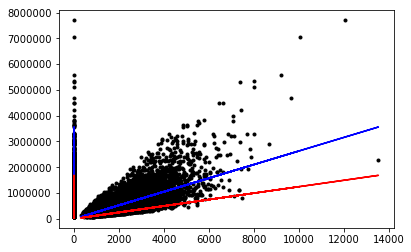

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(simple_feature_matrix,output,'k.',
         simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_0_penalty),'b-',
        simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-')

Compute the RSS on the TEST data for the following three sets of weights:

* The initial weights (all zeros)
* The weights learned with no regularization
* The weights learned with high regularization
* Which weights perform best?

* Ans3- line fit with no regularization


# Ques4- This question refers to the same model as the previous question.

Using the weights learned with high regularization (l2_penalty=1e11), make predictions for the TEST data. In which of the following ranges does the TEST error (RSS) fall?

In [16]:
initial_predictions = predict_output(simple_test_feature_matrix, initial_weights)
initial_residuals = test_output - initial_predictions
initial_RSS = (initial_residuals **2).sum()
print initial_RSS

1.78427328614e+15


In [20]:
no_regularization_predictions = predict_output(simple_test_feature_matrix, simple_weights_0_penalty)
no_regularization_residuals = test_output - no_regularization_predictions
no_regularization_RSS = (no_regularization_residuals **2).sum()
print no_regularization_RSS

2.75723632154e+14


In [18]:
regularization_predictions = predict_output(simple_test_feature_matrix, simple_weights_high_penalty)
regularization_residuals = test_output - regularization_predictions
regularization_RSS = (regularization_residuals **2).sum()
print regularization_RSS

6.9464210149e+14


Running a multiple regression with L2 penalty
Let us now consider a model with 2 features: ['sqft_living', 'sqft_living15'].

First, create Numpy versions of your training and test data with these two features.

In [19]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

We need to re-inialize the weights, since we have one extra parameter. Let us also set the step size and maximum number of iterations.

In [21]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

First, let's consider no regularization. Set the l2_penalty to 0.0 and run your ridge regression algorithm to learn the weights of your model. Call your weights:

multiple_weights_0_penalty

In [22]:
multiple_weights_0_penalty = ridge_regression_gradient_descent(feature_matrix, output, 
                                                               initial_weights, step_size, 
                                                               0.0, max_iterations)
print multiple_weights_0_penalty

[  -0.35743483  243.05416982   22.41481497]


Next, let's consider high regularization. Set the l2_penalty to 1e11 and run your ridge regression algorithm to learn the weights of your model. Call your weights:

multiple_weights_high_penalty

In [23]:
multiple_weights_high_penalty = ridge_regression_gradient_descent(feature_matrix, output, 
                                                               initial_weights, step_size, 
                                                               1e11, max_iterations)
print multiple_weights_high_penalty


[  6.74296579  91.48927365  78.43658766]


Compute the RSS on the TEST data for the following three sets of weights:

* The initial weights (all zeros)
* The weights learned with no regularization
* The weights learned with high regularization
* Which weights perform best?

In [24]:
initial_predictions = predict_output(test_feature_matrix, initial_weights)
initial_residuals = test_output - initial_predictions
initial_RSS = (initial_residuals **2).sum()
print initial_RSS

1.78427328614e+15


In [25]:
no_regularization_predictions = predict_output(test_feature_matrix, multiple_weights_0_penalty)
no_regularization_residuals = test_output - no_regularization_predictions
no_regularization_RSS = (no_regularization_residuals **2).sum()
print no_regularization_RSS

2.74067615919e+14


In [26]:
regularization_predictions = predict_output(test_feature_matrix, multiple_weights_high_penalty)
regularization_residuals = test_output - regularization_predictions
regularization_RSS = (regularization_residuals **2).sum()
print regularization_RSS

5.00404800501e+14


* Ans4- Between 2e14 and 5e14

Predict the house price for the 1st house in the test set using the no regularization and high regularization models. (Remember that python starts indexing from 0.) How far is the prediction from the actual price? Which weights perform best for the 1st house?

In [27]:
print no_regularization_predictions[0]
print test_output[0] - no_regularization_predictions[0]

387465.476058
-77465.4760582


In [28]:
print regularization_predictions[0]
print test_output[0] - regularization_predictions[0]

270453.530322
39546.4696781


# Ques5- We run ridge regression to learn the weights of a model that has two features (sqft_living, sqft_living15), once with l2_penalty=0.0 and once with l2_penalty=1e11.

What is the value of the coefficient for sqft_living that you learned with no regularization, rounded to 1 decimal place? Use American-style decimals (e.g. 30.5).

# Ques6- This question refers to the same model as the previous question.

What is the value of the coefficient for sqft_living that you learned with high regularization (l2_penalty=1e11)? Use American-style decimals (e.g. 30.5) and round your answer to 1 decimal place.

# Ques7- This question refers to the same model as the previous question.

Using the weights learned with high regularization (l2_penalty=1e11), make predictions for the TEST data. In which of the following ranges does the TEST error (RSS) fall?

# Ques8- This question refers to the same model as the previous question.

Predict the price of the first house in the test set using the weights learned with no regularization. Do the same using the weights learned with high regularization. Which weights make better prediction for the first house in the test set?

* Ans5- 243.1
* Ans6- 91.5
* Ans7- Between 4e14 and 8e14
* Ans8- The weight learned with high regularization